In [1]:
using QuranTree

In [2]:
using Yunir

In [24]:
using CairoMakie

In [3]:
"""
	Harakaat(char::Union{String, Char}, is_tanween::Bool)
Create a `Harakaat` object using `char` as the Arabic orthography, which is expected to be the 
short vowels, sukūn, and tanween.
```julia-repl
julia> fatha = arabic("a")
julia> Harakaat(fatha, false)
Harakaat("َ", false)
```
"""
struct Harakaat
	char::Union{String, Char}
	is_tanween::Bool
end

function Base.string(x::Harakaat)
	Harakaat(string(x.char), x.is_tanween)
end
Yunir.encode(x::Harakaat) = Harakaat(encode(string(x.char)), x.is_tanween)
Yunir.arabic(x::Harakaat) = Harakaat(arabic(string(x.char)), x.is_tanween)

Base.occursin(x::String, y::Harakaat) = occursin(x, y.char)
function Base.broadcasted(::typeof(in), s::AbstractString, mss::Vector{Harakaat})
	return [occursin(s, ms) for ms ∈ mss]
end

In [4]:
const AR_VOWELS = [
	Harakaat(Char(0x064B) |> string, true),
	Harakaat(Char(0x064C) |> string, true),
	Harakaat(Char(0x064D) |> string, true),
	Harakaat(Char(0x064E) |> string, false),
	Harakaat(Char(0x064F) |> string, false),
	Harakaat(Char(0x0650) |> string, false),
]
const BW_VOWELS = encode.(AR_VOWELS)
const AR_LONG_VOWELS = [
	Char(0x064A) |> string,
	Char(0x0648) |> string,
	Char(0x0627) |> string,
	Char(0x0670) |> string
]
const BW_LONG_VOWELS = encode.(AR_LONG_VOWELS)

4-element Vector{String}:
 "y"
 "w"
 "A"
 "`"

In [5]:
"""
	Segment(text::String, harakaat::Array{Harakaat})
Create a `Segment` object from `text`, which is the form of the segments of syllables, 
where vowels of which are also listed as `harakaat`.
```julia-repl
julia> bw_segment = "~aH?Hiy"
julia> Segment(bw_segment, Harakaat[Harakaat("a", false), Harakaat("i", false)])
Segment("~aH?Hiy", Harakaat[Harakaat("a", false), Harakaat("i", false)])
```
"""
struct Segment
	segment::String
	harakaat::Array{Harakaat}
end
Yunir.encode(x::Segment) = Segment(encode(x.segment), encode.(x.harakaat))
Yunir.arabic(x::Segment) = Segment(arabic(x.segment), encode.(x.harakaat))

In [6]:
"""
	Syllable{T <: Number}(
	    lead_nchars::T,
	    trail_nchars::T,
	    nvowels::T
    )
Create a `Syllable` object specifying the number of vowels `nvowels` to capture, and 
also the number of leading (`lead_nchars`) and trailing characters (`trail_nchars`) 
around the vowel. This object is used as an input for the `Rhyme` object.
The following code creates a `Syllable`, which specifies 3 syllables with 1 leading and trailing characters to include.
```julia-repl
julia> Syllable(1, 1, 3)
Syllable{Int64}(1, 1, 3)
```
"""
struct Syllable{T <: Number}
	lead_nchars::T
	trail_nchars::T
	nvowels::T
end

Syllable

In [7]:
"""
	Rhyme(is_quran::Bool, syllable::Syllable)
Create a `Rhyme` object with specifics for the `syllable` contructed through `Syllable`. 
It also takes argument for `is_quran` to handle Qur'an input, which does not recite the last vowel in every last word of the verse.
The following code creates a `Syllable`, which specifies 3 syllables with 1 leading and trailing characters to include.
```julia-repl
julia> ar_raheem_alamiyn = ["ٱلرَّحِيمِ", "ٱلْعَٰلَمِينَ"]
2-element Vector{String}:
 "ٱلرَّحِيمِ"
 "ٱلْعَٰلَمِينَ"
julia> r = Syllabification(true, Syllable(1, 1, 3))
Rhyme(true, Syllable{Int64}(1, 1, 3))
julia> output = r.(ar_raheem_alamiyn, true)
2-element Vector{Segment}:
 Segment("َّح?حِي", Harakaat[Harakaat("َ", false), Harakaat("ِ", false)])
 Segment("عَٰ?لَم?مِي", Harakaat[Harakaat("َ", false), Harakaat("َ", false), Harakaat("ِ", false)])
julia> encode.(output)
2-element Vector{Segment}:
 Segment("~aH?Hiy", Harakaat[Harakaat("a", false), Harakaat("i", false)])
 Segment("Ea`?lam?miy", Harakaat[Harakaat("a", false), Harakaat("a", false), Harakaat("i", false)])
```
"""
struct Syllabification
	silent_vowel::Bool
	syllable::Syllable
end

Syllabification

In [8]:
function count_vowels(text::String, isarabic::Bool=false)
    text = isarabic ? encode(text) : text
	jvowels = join([c.char for c in BW_VOWELS])
    return count(c -> c in jvowels, text)
end
function vowel_indices(text::String, isarabic::Bool=false)
    text = isarabic ? encode(text) : text
	jvowels = join([c.char for c in BW_VOWELS])
	return findall(c -> c in jvowels, text)
end
"""
	(r::Syllabification)(text::String, isarabic::Bool=false)
Call function for the `Syllabification` object. It extracts the rhyme features of `text` using the options
from the `Syllabification` object specified by `r`. It can handle both Arabic and Buckwalter input by toggling `isarabic`. 

Note: This will only work with @transliterator :default
```julia-repl
julia> ar_raheem = "ٱلرَّحِيمِ"
"ٱلرَّحِيمِ"
julia> r = Syllabification(true, Syllable(1, 2, 1))
Syllabification(true, Syllable{Int64}(1, 2, 1))
julia> output = r(ar_raheem, true)
Segment("حِيم", Harakaat[Harakaat("ِ", false)])
julia> encode(output)
Segment("Hiym", Harakaat[Harakaat("i", false)])
```
"""
function (r::Syllabification)(text::String; isarabic::Bool=false, first_word::Bool=false, silent_last_vowel::Bool=false)
    jvowels = join([c.char for c in BW_VOWELS])
	text = isarabic ? encode(text) : text
	
	vowel_idcs = vowel_indices(text, isarabic)
	harakaat = Harakaat[]
	segment_text = ""
	
	if length(vowel_idcs) == 0
		# since there is no vowel here, the name of the orthography as to how it is read will
		# be considered in recitation, meaning the vowels in the names of these letters will be used
		# instead of the explicit Arabic vowels
		orthogs = parse(Orthography, arabic(text)).data
		i = 1;
		for orthog in orthogs
			orthog = string(orthog)
			if orthog == "Maddah"
				i += 1
				continue
			else
				# if the name of the orthography is spelled with e instead of i, use i
				if occursin('e', orthog)
					push!(harakaat, BW_VOWELS[findfirst(x -> x.char == "i", BW_VOWELS)])
				elseif occursin('o', orthog) # cases like Noon
					push!(harakaat, BW_VOWELS[findfirst(x -> x.char == "u", BW_VOWELS)])
				else
					# otherwise, extract the vowels from the name of the orthography
					name_vowel_idcs = findall(x -> x in jvowels, lowercase(orthog))
					for vowel in lowercase(orthog[name_vowel_idcs])
						cond = string(vowel) .∈ BW_VOWELS
						if sum(cond) > 0
							push!(harakaat, BW_VOWELS[cond][1])
						else
							continue
						end
					end
				end

				consonant = ""
				if i+1 < length(text)
					if text[i+1] != '^'
						consonant = text[i] * "?"
					else
						consonant = text[i:i+1] * "?"
					end 
				elseif i+1 == length(text)
					if text[i+1] == '^'
						consonant = text[i:i+1]
					elseif text[i+1] == '~'
						consonant = text[i:i+1]
						segment_text *= consonant
						break # break already since the length of the text is equal to i+1
					else
						consonant = text[i] * "?"
					end 
				else
					consonant = text[i]
				end

				segment_text *= consonant
				i += 1
			end
		end
		return Segment(segment_text, harakaat)
	end
	
	if silent_last_vowel
		cond = string(text[end]) .∈ BW_VOWELS
		is_silent = sum(cond)
		penalty = is_silent < 1 ? 1 : 0
	else 
		is_silent = 0
		penalty = 1
	end

	# uplimit accounts exclusion of silent last vowel
	uplimit = r.syllable.nvowels > (count_vowels(text, isarabic) - is_silent) ? (count_vowels(text, isarabic) - is_silent) : r.syllable.nvowels
	k = 1
	for i in 0:(uplimit-is_silent-penalty)
		vowel_idx = vowel_idcs[end-i-is_silent]

		# checks if the input has vowels
		cond = string(text[vowel_idx]) .∈ BW_VOWELS

		# if it has at least one vowel
		if sum(cond) > 0
			push!(harakaat, isarabic ? arabic(BW_VOWELS[cond][1]) : BW_VOWELS[cond][1])
			lead_length = length(text[1:(vowel_idx-1)])
			trail_length = length(text[(vowel_idx+1):end])
			lead_nchars_lwlimit = lead_length > r.syllable.lead_nchars ? r.syllable.lead_nchars : lead_length
			trail_nchars_uplimit = trail_length > r.syllable.trail_nchars ? r.syllable.trail_nchars : trail_length
			vowel = text[vowel_idx]
			lead_text = text[(vowel_idx-lead_nchars_lwlimit):(vowel_idx-1)]
			trail_text = text[(vowel_idx+1):(vowel_idx+trail_nchars_uplimit)]
			
			# if given word is a first word 
			if first_word && r.syllable.nvowels > (length(vowel_idcs) - is_silent) && (k+1) > (length(vowel_idcs) - is_silent)
				if text[1] == '{'
					if r.syllable.trail_nchars > 0
						first_word_trail = text[2:(1+r.syllable.trail_nchars)]
					else
						first_word_trail = ""
					end
					first_word_text = "{" * first_word_trail * "?" 
					first_word_harakaat = filter(x -> x.char == "a", BW_VOWELS)[1]
					push!(harakaat, isarabic ? arabic(first_word_harakaat) : first_word_harakaat)
				else 
					first_word_text = ""
				end
			else
				first_word_text = ""
			end
			# add alif-maddah for first word as it is not silent
			if (text[vowel_idx-lead_nchars_lwlimit] == '~')
				lead_candidate1 = text[vowel_idx-lead_nchars_lwlimit-1]
				lead_text = lead_candidate1 * lead_text
			end

			if r.syllable.trail_nchars <= 1
				if (vowel_idx+trail_nchars_uplimit+1 <= length(text))
					trail_candidate1 = text[vowel_idx+trail_nchars_uplimit+1] # v + [tr1] (if trail = 0) 
					lvowel_cond = trail_candidate1 .∈ BW_LONG_VOWELS
					# next trail character is a maddah, e.g.  "ٱلضَّآلِّينَ" -> "{lD~aA^l~iyna"
					if (trail_candidate1 == '^')
						trail_text *= trail_candidate1
					end
					if (r.syllable.trail_nchars == 0) && (vowel_idx+trail_nchars_uplimit+2 <= length(text))
						trail_candidate2 = text[vowel_idx+trail_nchars_uplimit+2]
						# trail candidate is a long vowel
						if sum(lvowel_cond) > 0 && trail_candidate2 != 'o'
							if silent_last_vowel && k == (uplimit-is_silent-penalty) # k suggest that this applies to last syllable of last word only
								trail_text *= trail_candidate1 * trail_candidate2
							else
								trail_text *= trail_candidate1
							end
						# trail candidate is a long vowel but with sukuun, so it is a consonant with no vowel
						elseif sum(lvowel_cond) > 0 && trail_candidate2 == 'o'
							trail_text *= trail_candidate1
						# trail candidate is a consonant with sukuun
						elseif sum(lvowel_cond) == 0 && sum(string(trail_candidate1) .∈ BW_VOWELS) == 0 && trail_candidate2 == 'o' && r.syllable.trail_nchars > 0
							trail_text *= trail_candidate1
						# trail candidate is a consonant but is silent
						elseif sum(lvowel_cond) == 0 && sum(string(trail_candidate1) .∈ BW_VOWELS) == 0 && trail_candidate2 != 'o' && r.syllable.trail_nchars > 0 && silent_last_vowel && k == (uplimit-is_silent-penalty)
							trail_text *= trail_candidate1
						# trail candidate is a consonant not silent 
						elseif sum(lvowel_cond) == 0 && sum(string(trail_candidate1) .∈ BW_VOWELS) != 0 && trail_candidate2 != 'o' && r.syllable.trail_nchars > 0 && !silent_last_vowel
							trail_text *= trail_candidate1
						# think of other possibilities for else
						end		
					end
				end
			end
			if i == 0
				segment_text = first_word_text * lead_text * vowel * trail_text
			else
				segment_text = first_word_text * lead_text * vowel * trail_text * "?" * segment_text
			end
		else
			continue
		end
		k += 1
	end
    if isarabic
        return Segment(arabic(segment_text), reverse(harakaat))
	else
        return Segment(segment_text, reverse(harakaat))
    end
end

Syllabification

In [9]:
"""
	syllabic_consistency(segments::Vector{Segment}, syllable_timings::Dict{String,Int64})

Compute syllabic_consistency from a given `segments` and `syllable_timings`. THIS WILL ONLY WORK IF THE VOWEL HAS ONLY 1 TRAIL
```julia-repl
julia> using Yunir
julia> using QuranTree
julia> crps, tnzl = load(QuranData());
julia> crpstbl = table(crps)
julia> tnzltbl = table(tnzl)
julia> bw_texts = verses(tnzltbl[2])
julia> texts = string.(split(bw_texts[1]))
julia> r = Syllabification(true, Syllable(1, 0, 5))
julia> segments = Segment[]
julia> j = 1
julia> for i in texts
			if j == 1
				push!(segments, r(encode(i), isarabic=false, first_word=true, silent_last_vowel=false))
			elseif j == length(texts)
				push!(segments, r(encode(i), isarabic=false, first_word=false, silent_last_vowel=true))
			else
				push!(segments, r(encode(i), isarabic=false, first_word=false, silent_last_vowel=false))
			end
			j += 1
		end
julia> tajweed_timings = Dict{String,Int64}(
			"i"  => 1,
			"a"  => 1,
			"u"  => 1,
			"F"  => 1,
			"N"  => 1,
			"K"  => 1,
			"iy" => 2,
			"aA" => 2,
			"uw" => 2,
			"^"  => 4
		)
julia> syllabic_consistency(segments, tajweed_timings)
"""
function syllabic_consistency(segments::Vector{Segment}, syllable_timings::Dict{String,Int64})
    segment_scores = Int64[]
    for segment in segments
        syllables = split(segment.segment, "?")
        syllable_scores = Int64[]
        for syllable in syllables
            if occursin('{', syllable)
                push!(syllable_scores, syllable_timings["a"])
            else
                vowel_idcs = vowel_indices(string(syllable))
                vowel = syllable[vowel_idcs]
                if length(vowel_idcs) < 1
                    if occursin('^', syllable)
                        syllable_score = syllable_timings["^"]
                    else
                        syllable_score = minimum(values(syllable_timings)) # ?
                    end
                else
                    if vowel_idcs[end] < length(syllable)
                        next_letter = syllable[vowel_idcs .+ 1]
                        cond = (vowel == "a" && next_letter == "A") || 
                               (vowel == "i" && next_letter == "y") ||
                               (vowel == "u" && next_letter == "w")
                        if cond
                            if occursin('^', syllable)
                                syllable_score = syllable_timings["^"]
                            else
                                syllable_score = syllable_timings[vowel * next_letter]
                            end
                        else
                            syllable_score = syllable_timings[vowel]
                        end
                    else
                        syllable_score = syllable_timings[vowel]
                    end
                end
                push!(syllable_scores, syllable_score)
            end
        end
        push!(segment_scores, syllable_scores...)
    end
    return segment_scores
end

syllabic_consistency

### Load Data

In [12]:
_, tnzl = load(QuranData());
tnzltbl = table(tnzl)

Tanzil Quran Text (Uthmani)
(C) 2008-2010 Tanzil.net

6236×3 DataFrame
  Row │ chapter  verse  form                              
      │ Int64    Int64  String                            
──────┼───────────────────────────────────────────────────
    1 │       1      1  بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ
    2 │       1      2  ٱلْحَمْدُ لِلَّهِ رَبِّ ٱلْعَٰلَمِينَ
    3 │       1      3  ٱلرَّحْمَٰنِ ٱلرَّحِيمِ
    4 │       1      4  مَٰلِكِ يَوْمِ ٱلدِّينِ
    5 │       1      5  إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ
    6 │       1      6  ٱهْدِنَا ٱلصِّرَٰطَ ٱلْمُسْتَقِيمَ
    7 │       1      7  صِرَٰطَ ٱلَّذِينَ أَنْعَمْتَ عَلَيْهِمْ غَيْرِ ٱلْمَغْضُو…
    8 │       2      1  بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ الٓمٓ
    9 │       2      2  ذَٰلِكَ ٱلْكِتَٰبُ لَا رَيْبَ فِيهِ هُدًى لِّلْمُتَّقِينَ
   10 │       2      3  ٱلَّذِينَ يُؤْمِنُونَ بِٱلْغَيْبِ وَيُقِيمُونَ ٱلصَّل…
   11 │       2      4  وَٱلَّذِينَ يُؤْمِنُونَ بِمَآ أُنزِلَ إِلَيْكَ وَمَآ …
  ⋮   │    ⋮ 

In [13]:
bw_texts = verses(tnzltbl)

6236-element Vector{String}:
 "بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ"
 "ٱلْحَمْدُ لِلَّهِ رَبِّ ٱلْعَٰلَمِينَ"
 "ٱلرَّحْمَٰنِ ٱلرَّحِيمِ"
 "مَٰلِكِ يَوْمِ ٱلدِّينِ"
 "إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ"
 "ٱهْدِنَا ٱلصِّرَٰطَ ٱلْمُسْتَقِيمَ"
 "صِرَٰطَ ٱلَّذِينَ أَنْعَمْتَ عَ" ⋯ 55 bytes ⋯ "عَلَيْهِمْ وَلَا ٱلضَّآلِّينَ"
 "بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ الٓمٓ"
 "ذَٰلِكَ ٱلْكِتَٰبُ لَا رَيْبَ فِيهِ هُدًى لِّلْمُتَّقِينَ"
 "ٱلَّذِينَ يُؤْمِنُونَ بِٱلْغَيْ" ⋯ 59 bytes ⋯ "ِمَّا رَزَقْنَٰهُمْ يُنفِقُونَ"
 "وَٱلَّذِينَ يُؤْمِنُونَ بِمَآ " ⋯ 88 bytes ⋯ "بِٱلْءَاخِرَةِ هُمْ يُوقِنُونَ"
 "أُو۟لَٰٓئِكَ عَلَىٰ هُدًى مِّن رَّبِّهِمْ وَأُو۟لَٰٓئِكَ هُمُ ٱلْمُفْلِحُونَ"
 "إِنَّ ٱلَّذِينَ كَفَرُوا۟ سَوَا" ⋯ 72 bytes ⋯ "مْ تُنذِرْهُمْ لَا يُؤْمِنُونَ"
 ⋮
 "وَلَمْ يَكُن لَّهُۥ كُفُوًا أَحَدٌۢ"
 "بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ قُلْ أَعُوذُ بِرَبِّ ٱلْفَلَقِ"
 "مِن شَرِّ مَا خَلَقَ"
 "وَمِن شَرِّ غَاسِقٍ إِذَا وَقَبَ"
 "وَمِن شَرِّ ٱلنَّفَّٰثَٰتِ فِى ٱلْعُقَدِ"
 "وَمِن شَرِّ حَاسِد

In [16]:
texts = map(x -> string.(x), split.(bw_texts))

6236-element Vector{Vector{String}}:
 ["بِسْمِ", "ٱللَّهِ", "ٱلرَّحْمَٰنِ", "ٱلرَّحِيمِ"]
 ["ٱلْحَمْدُ", "لِلَّهِ", "رَبِّ", "ٱلْعَٰلَمِينَ"]
 ["ٱلرَّحْمَٰنِ", "ٱلرَّحِيمِ"]
 ["مَٰلِكِ", "يَوْمِ", "ٱلدِّينِ"]
 ["إِيَّاكَ", "نَعْبُدُ", "وَإِيَّاكَ", "نَسْتَعِينُ"]
 ["ٱهْدِنَا", "ٱلصِّرَٰطَ", "ٱلْمُسْتَقِيمَ"]
 ["صِرَٰطَ", "ٱلَّذِينَ", "أَنْعَمْتَ", "عَلَيْهِمْ", "غَيْرِ", "ٱلْمَغْضُوبِ", "عَلَيْهِمْ", "وَلَا", "ٱلضَّآلِّينَ"]
 ["بِسْمِ", "ٱللَّهِ", "ٱلرَّحْمَٰنِ", "ٱلرَّحِيمِ", "الٓمٓ"]
 ["ذَٰلِكَ", "ٱلْكِتَٰبُ", "لَا", "رَيْبَ", "فِيهِ", "هُدًى", "لِّلْمُتَّقِينَ"]
 ["ٱلَّذِينَ", "يُؤْمِنُونَ", "بِٱلْغَيْبِ", "وَيُقِيمُونَ", "ٱلصَّلَوٰةَ", "وَمِمَّا", "رَزَقْنَٰهُمْ", "يُنفِقُونَ"]
 ["وَٱلَّذِينَ", "يُؤْمِنُونَ", "بِمَآ", "أُنزِلَ", "إِلَيْكَ", "وَمَآ", "أُنزِلَ", "مِن", "قَبْلِكَ", "وَبِٱلْءَاخِرَةِ", "هُمْ", "يُوقِنُونَ"]
 ["أُو۟لَٰٓئِكَ", "عَلَىٰ", "هُدًى", "مِّن", "رَّبِّهِمْ", "وَأُو۟لَٰٓئِكَ", "هُمُ", "ٱلْمُفْلِحُونَ"]
 ["إِنَّ", "ٱلَّذِينَ", "كَفَرُوا۟", "سَوَآءٌ", "عَلَيْهِ

In [17]:
r = Syllabification(true, Syllable(1, 1, 10))

Syllabification(true, Syllable{Int64}(1, 1, 10))

In [18]:
tajweed_timings = Dict{String,Int64}(
    "i" => 1, # kasra
    "a" => 1, # fatha
    "u" => 1, # damma
    "F" => 1, # fatha tanween
    "N" => 1, # damma tanween
    "K" => 1, # kasra tanween
    "iy" => 2, # kasra + yaa
    "aA" => 2, # fatha + alif
    "uw" => 2, # damma + waw
    "^" => 6 # maddah
)

Dict{String, Int64} with 10 entries:
  "iy" => 2
  "aA" => 2
  "uw" => 2
  "N"  => 1
  "^"  => 6
  "u"  => 1
  "K"  => 1
  "a"  => 1
  "F"  => 1
  "i"  => 1

In [20]:
all_segments = []
k = 1
for text in texts
    segments = Segment[]
    j = 1
    for i in text
        if j == 1
            push!(segments, r(encode(i), isarabic=false, first_word=true, silent_last_vowel=false))
        elseif j == length(text)
            push!(segments, r(encode(i), isarabic=false, first_word=false, silent_last_vowel=true))
        else
            push!(segments, r(encode(i), isarabic=false, first_word=false, silent_last_vowel=false))
        end
        j += 1
    end
    k += 1
    push!(all_segments, segments)
end

In [21]:
out = map(segments -> syllabic_consistency(segments, tajweed_timings), all_segments)

6236-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 1, 1, 1, 2]
 [1, 1, 1, 1, 1, 2]
 [2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2]
 [1, 1, 2, 1, 1, 1, 1, 1, 2]
 [1, 1, 1, 1, 2, 1, 1, 1, 1, 1  …  1, 2, 1, 1, 1, 1, 1, 2, 6, 2]
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 6]
 [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 2, 1, 1, 1, 2, 1, 1, 1  …  1, 1, 2, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 2, 1, 1, 1, 2, 1, 1, 6  …  1, 1, 2, 1, 1, 1, 1, 2, 1, 2]
 [2, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 2, 1, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 1, 2, 1, 1, 1, 2, 1, 6  …  1, 1, 1, 1, 1, 1, 2, 1, 1, 2]
 ⋮
 [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 2, 1, 1]
 [1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2]
 [1, 1, 1, 2]
 [1, 1, 1, 2]
 [1, 1, 1, 1, 2, 1, 1, 2]
 [1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2

In [176]:
findfirst(length.(out) .== maximum(length.(out)))

289

In [181]:
286+7

293

In [182]:
293-289

4

In [183]:
286-4

282

In [186]:
print.(verses(tnzltbl[2][282]))

يَٰٓأَيُّهَا ٱلَّذِينَ ءَامَنُوٓا۟ إِذَا تَدَايَنتُم بِدَيْنٍ إِلَىٰٓ أَجَلٍ مُّسَمًّى فَٱكْتُبُوهُ وَلْيَكْتُب بَّيْنَكُمْ كَاتِبٌۢ بِٱلْعَدْلِ وَلَا يَأْبَ كَاتِبٌ أَن يَكْتُبَ كَمَا عَلَّمَهُ ٱللَّهُ فَلْيَكْتُبْ وَلْيُمْلِلِ ٱلَّذِى عَلَيْهِ ٱلْحَقُّ وَلْيَتَّقِ ٱللَّهَ رَبَّهُۥ وَلَا يَبْخَسْ مِنْهُ شَيْـًٔا فَإِن كَانَ ٱلَّذِى عَلَيْهِ ٱلْحَقُّ سَفِيهًا أَوْ ضَعِيفًا أَوْ لَا يَسْتَطِيعُ أَن يُمِلَّ هُوَ فَلْيُمْلِلْ وَلِيُّهُۥ بِٱلْعَدْلِ وَٱسْتَشْهِدُوا۟ شَهِيدَيْنِ مِن رِّجَالِكُمْ فَإِن لَّمْ يَكُونَا رَجُلَيْنِ فَرَجُلٌ وَٱمْرَأَتَانِ مِمَّن تَرْضَوْنَ مِنَ ٱلشُّهَدَآءِ أَن تَضِلَّ إِحْدَىٰهُمَا فَتُذَكِّرَ إِحْدَىٰهُمَا ٱلْأُخْرَىٰ وَلَا يَأْبَ ٱلشُّهَدَآءُ إِذَا مَا دُعُوا۟ وَلَا تَسْـَٔمُوٓا۟ أَن تَكْتُبُوهُ صَغِيرًا أَوْ كَبِيرًا إِلَىٰٓ أَجَلِهِۦ ذَٰلِكُمْ أَقْسَطُ عِندَ ٱللَّهِ وَأَقْوَمُ لِلشَّهَٰدَةِ وَأَدْنَىٰٓ أَلَّا تَرْتَابُوٓا۟ إِلَّآ أَن تَكُونَ تِجَٰرَةً حَاضِرَةً تُدِيرُونَهَا بَيْنَكُمْ فَلَيْسَ عَلَيْكُمْ جُنَاحٌ أَلَّا تَكْتُبُوهَا وَأَشْهِدُوٓا۟ إِذَا 

1-element Vector{Nothing}:
 nothing

In [99]:
out[map(x -> length(x) == 3, out)]

2-element Vector{Vector{Int64}}:
 [6, 6, 6]
 [2, 6, 1]

In [170]:
len = 200
data_matrix = hcat(out[map(x -> length(x) == len, out)]...)

Any[]

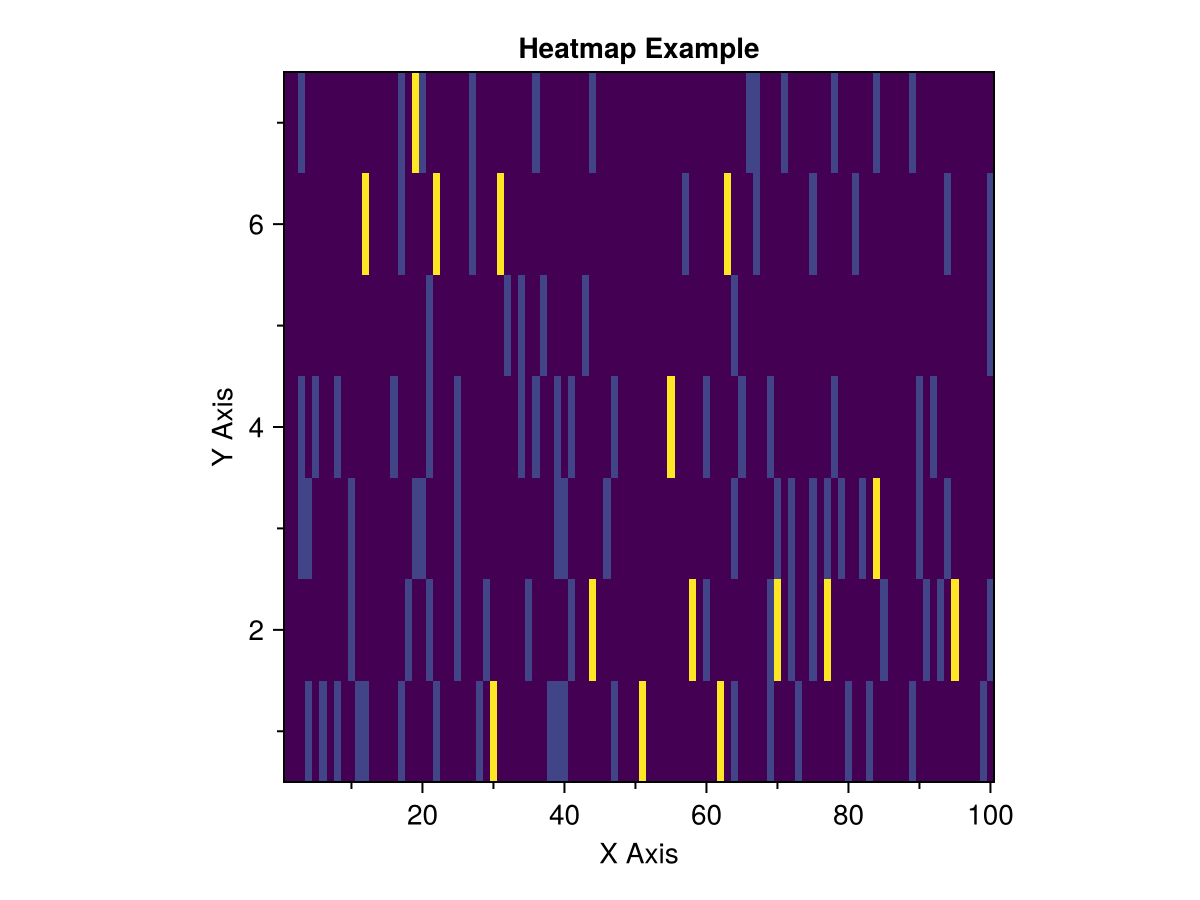

In [169]:
fig = Figure()

# Create an axis within the figure
ax = Axis(fig[1, 1], 
    xlabel = "X Axis", 
    ylabel = "Y Axis", 
    title = "Heatmap Example",
    xminorticksvisible = true,
    yminorticksvisible = true,
    # xticks = (1:len, string.(1:len)),
    aspect = AxisAspect(1.),
    # yticks = (1:size(data_matrix)[2], string.(1:size(data_matrix)[2]))
)
centers_x = 1:len
centers_y = 1:size(data_matrix)[2]
heatmap!(ax, centers_x, centers_y, data_matrix) # Set the range based on your data
fig